このPython コードは、PyMC を使ってMCMCサンプリングを行います。
* 2025年8月時点では、Google Colaboratory環境では PyMC がそのまま使えますので、実行可能です。
* ローカルな計算機環境では、PyMC パッケージが含まれていないのが一般的です。
    * 例えば、Anaconda などの Distribution では、以下の例の様に、PyMC環境を用意する必要があります。
        ```
        conda create -c conda-forge -n pymc_env pymc
        conda activate pymc_env
        conda install conda-forge::ipywidgets
        conda install scikit-learn
        ```
        * これで VS codeの実行時のPython環境に、```pymc_env```を選択します。

In [ ]:
############################################
BaseDir      = 'IntroDDSJpn/Chap02/'
OutputDir    = '2Prior-060104VonMises/'
FileBaseName = '2Prior-060104VonMises'

* Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [ ]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

Mounted at /content/drive
ipynb file path = drive/My Drive/Colab Notebooks/IntroDDS/Chap02/


* 必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
print('numpy      Ver.', np.__version__)
#
############################################
# https://docs.pymc.io/
import pymc as pm
import time
print('pymc       Ver.', pm.__version__)
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.7.1
numpy      Ver. 1.26.4
pymc       Ver. 5.10.4
FilePath = drive/My Drive/Colab Notebooks/IntroDDS/Chap02/2Prior-060104VonMises/
  making drive/My Drive/Colab Notebooks/IntroDDS/Chap02/2Prior-060104VonMises/


---
周期的変数の事前確率には、フォン・ミーゼス(von Mises)分布が用いられる。
* https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.VonMises.html
* これは円周上に定義された確率分布関数と考えることが可能で、円周正規(circular noraml)分布とも呼ばれる。
* 確率分布関数は以下の通りである。
$$
f(x|\mu,\kappa)
=
\frac{
  \exp
  \left[
    \kappa
    \cos(x-\mu)
  \right]
}{
  2\pi
  I_{0}(\kappa)
}
,
$$
ここで$I_{0}(\kappa)$は、第一種変形ベッセル関数で、pythonでは、scipyパッケージの scipy.special.iv() が利用できる。
  * scipy.special.iv(v,z) $=I_{v}(z)$
  * https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.iv.html

In [4]:
############################################
# フォン・ミーゼス(von Mises)分布
from scipy.special import iv
#
pi2 = 2 * np.pi
#
def PVonMises(x, mu, kappa):
  I0kappa2pi = pi2 * iv( 0, kappa )
  return np.exp( kappa * np.cos(x - mu) ) / I0kappa2pi

In [5]:
############################################
mu1    = 0.0
kappa1 = 0.01
mu2    = 0.0
kappa2 = 0.5
mu3    = 0.0
kappa3 = 4.0
mu4    = -2.5
kappa4 = 2.0

In [6]:
############################################
xx = np.linspace( -np.pi, +np.pi, num=100)
PVonMises1 = PVonMises( xx, mu1, kappa1)
PVonMises2 = PVonMises( xx, mu2, kappa2)
PVonMises3 = PVonMises( xx, mu3, kappa3)
PVonMises4 = PVonMises( xx, mu4, kappa4)

In [7]:
############################################
with pm.Model() as  model:
    VMises1 = pm.VonMises('VonMises1',mu=mu1,kappa=kappa1)
    VMises2 = pm.VonMises('VonMises2',mu=mu2,kappa=kappa2)
    VMises3 = pm.VonMises('VonMises3',mu=mu3,kappa=kappa3)
    VMises4 = pm.VonMises('VonMises4',mu=mu4,kappa=kappa4)
    VonMises1 = pm.draw( VMises1, draws=100000)
    VonMises2 = pm.draw( VMises2, draws=100000)
    VonMises3 = pm.draw( VMises3, draws=100000)
    VonMises4 = pm.draw( VMises4, draws=100000)

In [8]:
############################################
def GrfHist(Dist, xx, yy, mu, kappa):
    hlabel = r'VonMises($\mu$=%.2f, $\kappa$=%.2f)' % (mu, kappa)
    ########################################
    plt.rcParams['font.size'] = 16
    #
    fig = plt.figure( figsize=(6,6) )
    fig.subplots_adjust(left=0.18,
                        right=0.97,
                        top=0.94,
                        bottom=0.1)
    #
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_xlabel( r'$x$')
    ax1.set_xlim( -np.pi, +np.pi )
    ax1.set_ylabel( 'Distribution' )
    #
    bin_values, bins, patches = ax1.hist(
        Dist,
        bins=100, density=True,
        label=hlabel)
    #
    bin_values_max = np.amax( bin_values )
    #
    (y_bot, y_top) = ax1.set_ylim((0,bin_values_max * 1.2))
    #
    ax1.plot( xx,yy )
    #
    plt.title( hlabel )
    #
    plt.legend()
    #
    plt.grid(True)
    #
    plt.show()
    #
    return fig

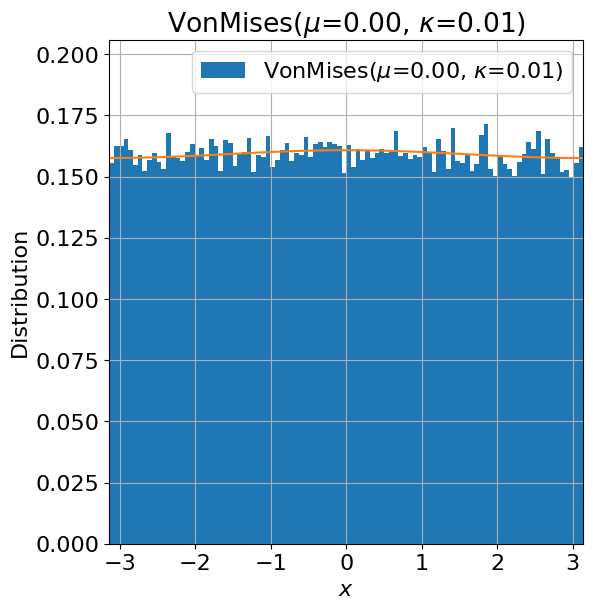

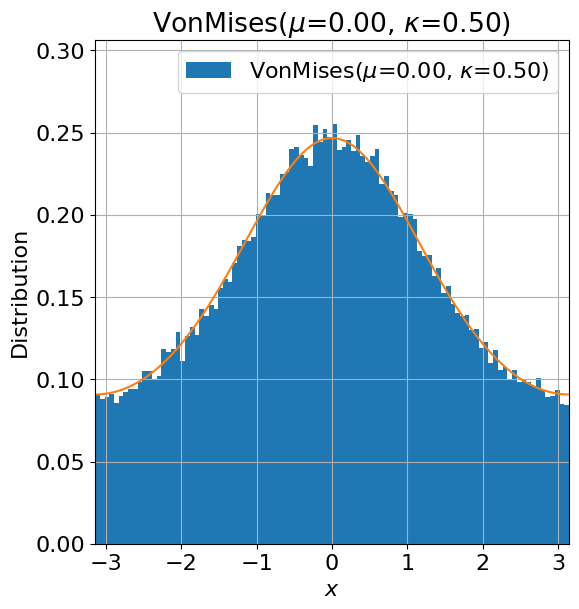

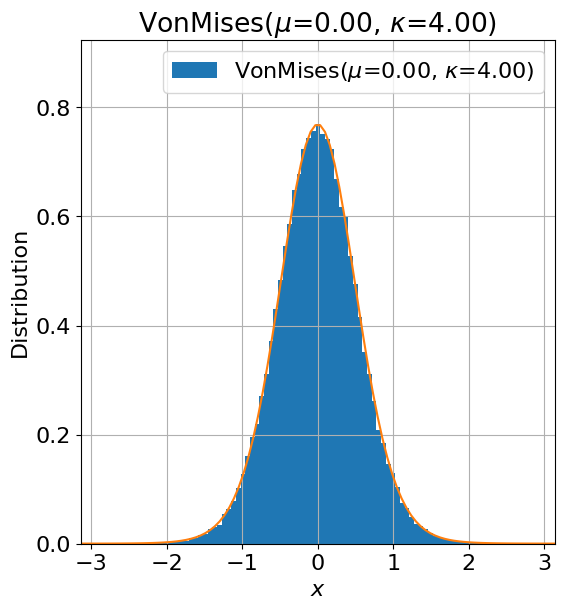

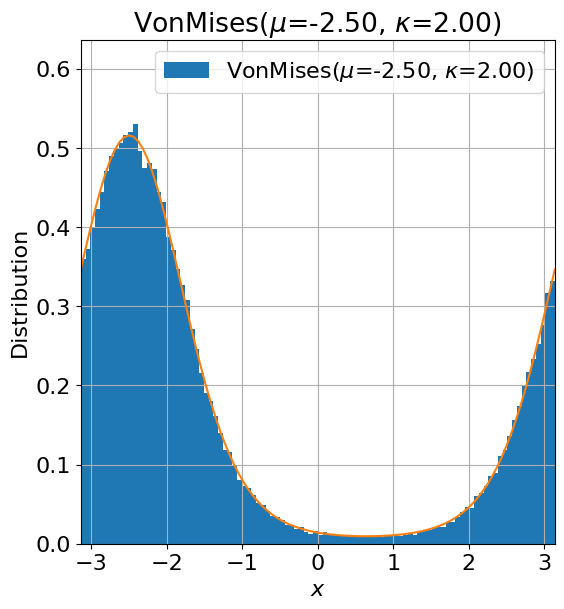

In [9]:
######################################
fig = GrfHist(VonMises1, xx, PVonMises1, mu1, kappa1)
pdfName = FilePath + FileBaseName + '-01.pdf'
fig.savefig( pdfName )
#
######################################
fig = GrfHist(VonMises2, xx, PVonMises2, mu2, kappa2)
pdfName = FilePath + FileBaseName + '-02.pdf'
fig.savefig( pdfName )
#
######################################
fig = GrfHist(VonMises3, xx, PVonMises3, mu3, kappa3)
pdfName = FilePath + FileBaseName + '-03.pdf'
fig.savefig( pdfName )
#
######################################
fig = GrfHist(VonMises4, xx, PVonMises4, mu4, kappa4)
pdfName = FilePath + FileBaseName + '-04.pdf'
fig.savefig( pdfName )
#